In [1]:
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.transforms import functional as TF
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import pandas as pd
import matplotlib.patches as mpatches
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import os
import gc
from sklearn.manifold import TSNE

In [2]:
from google.colab import drive
drive.mount('/content/drive')
def load_dataset(name):
    if name == 'salinas':
        data = sio.loadmat('/content/drive/My Drive/content/Salinas_corrected.mat')['salinas_corrected'].astype(np.float32)
        gt = sio.loadmat('/content/drive/My Drive/content/Salinas_gt.mat')['salinas_gt']
    elif name == 'pavia':
        data = sio.loadmat('/content/drive/My Drive/content/PaviaU.mat')['paviaU'].astype(np.float32)
        gt = sio.loadmat('/content/drive/My Drive/content/PaviaU_gt.mat')['paviaU_gt']
    elif name == 'indian':
        data = sio.loadmat('/content/drive/My Drive/content/Indian_pines_corrected.mat')['indian_pines_corrected'].astype(np.float32)
        gt = sio.loadmat('/content/drive/My Drive/content/Indian_pines_gt.mat')['indian_pines_gt']
    else:
        raise ValueError("Unsupported dataset name")
    return data, gt

Mounted at /content/drive


Loaded dataset: pavia
Data shape: (610, 340, 103)
Ground truth shape: (610, 340)


In [3]:
data, gt = load_dataset('pavia')

In [4]:
def preprocess(data, gt, dataset_name):
    h, w, bands = data.shape
    if dataset_name == 'indian':
        noisy_bands = [b for b in (list(range(104, 109)) + list(range(150, 164)) + [220]) if b < data.shape[-1]]
        data = np.delete(data, noisy_bands, axis=2)
    scaler = MinMaxScaler()
    data_reshaped = data.reshape(-1, data.shape[2])
    data_scaled = scaler.fit_transform(data_reshaped)
    pca_components = 30 if dataset_name == 'pavia' else 40
    pca = PCA(n_components=pca_components)
    data_pca = pca.fit_transform(data_scaled)
    data_pca = data_pca.reshape(h, w, -1)
    data_pca = (data_pca - np.min(data_pca)) / (np.max(data_pca) - np.min(data_pca))
    return data_pca, gt, h, w, pca_components


In [5]:


# Reduce hyperspectral data to 30 principal components
n_components = 30
reshaped_data = data.reshape(-1, data.shape[2])
pca = PCA(n_components=n_components, whiten=True)
pca_data = pca.fit_transform(reshaped_data)
data_pca = pca_data.reshape(data.shape[0], data.shape[1], n_components)

print("PCA-reduced data shape:", data_pca.shape)


PCA-reduced data shape: (610, 340, 30)


In [6]:
# ========== PATCH EXTRACTION ==========
def extract_patches(data, gt, patch_size):
    h, w, _ = data.shape
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='reflect')
    padded_gt = np.pad(gt, ((margin, margin), (margin, margin)), mode='reflect')
    patches, labels, coords = [], [], []
    for i in range(margin, margin + h):
        for j in range(margin, margin + w):
            patch = padded_data[i - margin:i + margin, j - margin:j + margin, :]
            label = padded_gt[i, j]
            if label != 0:
                patches.append(patch)
                labels.append(label)
                coords.append((i - margin, j - margin))
    return np.array(patches), np.array(labels), np.array(coords), h, w

# # Call the function
patch_size = 5
patches, labels, coords, h, w = extract_patches(data_pca, gt, patch_size=patch_size)
print("Patches shape:", patches.shape)


Patches shape: (42776, 4, 4, 30)


In [7]:
# # ========== FLATTEN PATCHES & DEFINE INPUT/OUTPUT SIZE ==========
patches = patches.reshape(patches.shape[0], -1)
input_dim = patches.shape[1]  # e.g., 5*5*30 = 750
latent_dim = 32               # Can experiment with 16, 64, etc.

print("Input dimension:", input_dim)


Input dimension: 480


In [8]:
# ========== PATCH AUTOENCODER MODEL ==========


class PatchAutoencoder(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super(PatchAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [9]:
# ========== TRAIN AUTOENCODER ==========

from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PatchAutoencoder(latent_dim=latent_dim, input_dim=input_dim).to(device)

patches_tensor = torch.tensor(patches, dtype=torch.float32).to(device)
dataset = TensorDataset(patches_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        x_hat = model(x)
        loss = loss_fn(x_hat, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")


Epoch 1/20, Loss: 0.5773
Epoch 2/20, Loss: 0.5329
Epoch 3/20, Loss: 0.5259
Epoch 4/20, Loss: 0.5276
Epoch 5/20, Loss: 0.5249
Epoch 6/20, Loss: 0.5242
Epoch 7/20, Loss: 0.5284
Epoch 8/20, Loss: 0.5259
Epoch 9/20, Loss: 0.5230
Epoch 10/20, Loss: 0.5211
Epoch 11/20, Loss: 0.5237
Epoch 12/20, Loss: 0.5184
Epoch 13/20, Loss: 0.5132
Epoch 14/20, Loss: 0.5087
Epoch 15/20, Loss: 0.5103
Epoch 16/20, Loss: 0.5096
Epoch 17/20, Loss: 0.5045
Epoch 18/20, Loss: 0.5025
Epoch 19/20, Loss: 0.5098
Epoch 20/20, Loss: 0.5095


In [10]:
with torch.no_grad():
    latent_features = model.encoder(patches_tensor).cpu().numpy()
print("Latent features shape:", latent_features.shape)  # Should be (54129, 32)


Latent features shape: (42776, 32)


In [11]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    latent_features, labels, coords, test_size=0.2, stratify=labels, random_state=42
)


# Train SVM
svm = SVC(kernel='rbf', C=10, gamma='scale')  # You can tune these later
svm.fit(X_train, y_train)

# Predict
y_pred = svm.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.983286582515194
Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.99      0.98      1326
           2       1.00      1.00      1.00      3730
           3       0.95      0.86      0.91       420
           4       1.00      1.00      1.00       613
           5       1.00      1.00      1.00       269
           6       0.99      0.99      0.99      1006
           7       0.99      0.99      0.99       266
           8       0.91      0.94      0.93       737
           9       1.00      0.99      1.00       189

    accuracy                           0.98      8556
   macro avg       0.98      0.97      0.98      8556
weighted avg       0.98      0.98      0.98      8556

Confusion Matrix:
 [[1310    0    1    0    0    0    3   12    0]
 [   0 3719    0    0    0   10    0    1    0]
 [   0    0  363    0    0    0    0   57    0]
 [   0    2    0  610    0    1    0    0    0]
 [   0    0    0    0  269    0 

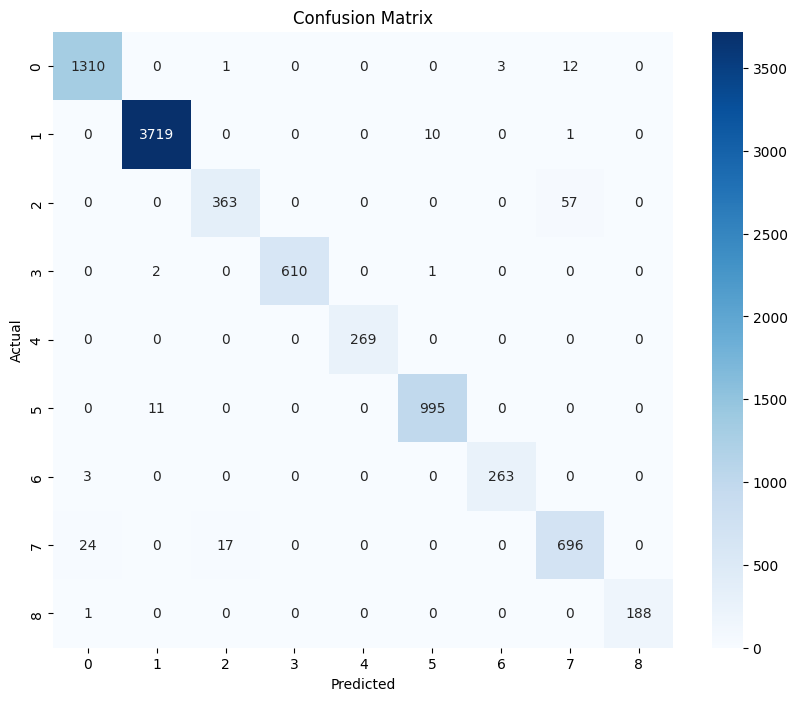

In [12]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:
# Create an argument parser
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='pavia', help='Dataset name:  indian, pavia,salinas')  # Added default value

# Parse the arguments, providing an empty list if no arguments are given
args, _ = parser.parse_known_args()  # Added _ to ignore unknown arguments
dataset_name = args.dataset # dataset_name is now defined here


In [14]:
# Get the metadata for the selected dataset
# Define the dataset_metadata dictionary and the get_dataset_metadata function
# before calling it to ensure it's correctly defined.

dataset_metadata = {

    'pavia': {
        'label_to_name': {
            1: 'Asphalt',
            2: 'Meadows',
            3: 'Gravel',
            4: 'Trees',
            5: 'Painted metal sheets',
            6: 'Bare Soil',
            7: 'Bitumen',
            8: 'Self-Blocking Bricks',
            9: 'Shadows'
        },
        'descriptions': {
            'Asphalt': "Urban road surface.",
            'Meadows': "Large grassy areas.",
            'Gravel': "Loose rock surface.",
            'Trees': "Vegetation cover.",
            'Painted metal sheets': "Reflective urban structures.",
            'Bare Soil': "Dry, unplanted earth.",
            'Bitumen': "Waterproof construction surface.",
            'Self-Blocking Bricks': "Interlocking brick patterns.",
            'Shadows': "Shadowed zones in urban area."
        }
    },
    'indian': {
        'label_to_name': {
            1: 'Alfalfa',
            2: 'Corn-notill',
            3: 'Corn-mintill',
            4: 'Corn',
            5: 'Grass-pasture',
            6: 'Grass-trees',
            7: 'Grass-pasture-mowed',
            8: 'Hay-windrowed',
            9: 'Oats',
            10: 'Soybean-notill',
            11: 'Soybean-mintill',
            12: 'Soybean-clean',
            13: 'Wheat',
            14: 'Woods',
            15: 'Buildings-Grass-Trees-Drives',
            16: 'Stone-Steel-Towers'
        },
        'descriptions': {
            'Alfalfa': "Perennial flowering plant.",
            'Corn-notill': "Corn grown without tillage.",
            'Corn-mintill': "Corn with minimal tillage.",
            'Corn': "Fully cultivated corn.",
            'Grass-pasture': "Grazing grassland.",
            'Grass-trees': "Mixed vegetation.",
            'Grass-pasture-mowed': "Cut pasture field.",
            'Hay-windrowed': "Dry hay laid in rows.",
            'Oats': "Cultivated oats.",
            'Soybean-notill': "Soybean without tillage.",
            'Soybean-mintill': "Soybean with light tillage.",
            'Soybean-clean': "Soybean grown cleanly.",
            'Wheat': "Wheat crop.",
            'Woods': "Dense trees.",
            'Buildings-Grass-Trees-Drives': "Urban mix with greenery.",
            'Stone-Steel-Towers': "Tall infrastructure features."
        }
    },
    'salinas': {
        'label_to_name': {
            1: "Broccoli_green_weeds_1",
            2: "Broccoli_green_weeds_2",
            3: "Fallow",
            4: "Fallow_rough_plow",
            5: "Fallow_smooth",
            6: "Stubble",
            7: "Celery",
            8: "Grapes_untrained",
            9: "Soil_vinyard_develop",
            10: "Corn_senesced_green_weeds",
            11: "Lettuce_romaine_4wk",
            12: "Lettuce_romaine_5wk",
            13: "Lettuce_romaine_6wk",
            14: "Lettuce_romaine_7wk",
            15: "Vinyard_untrained",
            16: "Vinyard_vertical_trellis"
        },
         'descriptions': {
            "Broccoli_green_weeds_1": "Weeds in broccoli field type 1.",
            "Broccoli_green_weeds_2": "Weeds in broccoli field type 2.",
            "Fallow": "Unplanted agricultural field.",
            "Fallow_rough_plow": "Rough-plowed, uncultivated land.",
            "Fallow_smooth": "Smooth, barren agricultural field.",
            "Stubble": "Remnants of harvested crops.",
            "Celery": "Celery vegetation detected.",
            "Grapes_untrained": "Grapevines not trained on trellis.",
            "Soil_vinyard_develop": "Soil under vineyard development.",
            "Corn_senesced_green_weeds": "Dried corn with weeds.",
            "Lettuce_romaine_4wk": "4-week romaine lettuce.",
            "Lettuce_romaine_5wk": "5-week romaine lettuce.",
            "Lettuce_romaine_6wk": "6-week romaine lettuce.",
            "Lettuce_romaine_7wk": "7-week romaine lettuce.",
            "Vinyard_untrained": "Untrained vineyard vines.",
            "Vinyard_vertical_trellis": "Vineyard with vertical trellis."
        }

    }
}

def get_dataset_metadata(dataset_name):
    return dataset_metadata.get(dataset_name.lower(), {'label_to_name': {}, 'descriptions': {}})

# Assuming dataset_name is already defined from argparse or other means
# For example: dataset_name = 'pavia_university' # or 'pavia', 'indian'

# Correct the dataset_name if necessary to match keys in dataset_metadata
if 'pavia' in dataset_name.lower():
    dataset_name_key = 'pavia'
elif 'indian' in dataset_name.lower():
    dataset_name_key = 'indian'
elif 'salinas' in dataset_name.lower():
    dataset_name_key = 'salinas'
else:
    # Handle cases where dataset_name is not recognized, maybe raise an error
    # or default to a known key if appropriate.
    # For this fix, we'll assume a known key or add a print statement.
    print(f"Warning: Dataset name '{dataset_name}' not recognized. Using default empty metadata.")
    dataset_name_key = None # Or a default like 'pavia' if desired

if dataset_name_key:
    metadata = get_dataset_metadata(dataset_name_key)
else:
    metadata = {'label_to_name': {}, 'descriptions': {}} # Provide default empty metadata


In [15]:
# Get the metadata for the selected dataset
metadata = get_dataset_metadata(dataset_name)

# Assign label_to_name to label_names
label_names = metadata['label_to_name']
descriptions = metadata['descriptions']

In [16]:

if dataset_name == 'indian':
    patch_size = 5
    n_components = 30
elif dataset_name == 'pavia':
    patch_size = 3
    n_components = 20
elif dataset_name == 'salinas':
    patch_size = 5
    n_components = 30


In [17]:


# Assuming 'patches_tensor' from the previous cell contains the correct data
patches = patches_tensor.cpu().numpy() # Get NumPy array from the tensor

# Ensure it's a float32 NumPy array (should already be, but this is a safety check)
patches = patches.astype(np.float32)

# Convert to tensor and move to device
patches_tensor = torch.tensor(patches).to(device)

# Run through the model
model.eval()
with torch.no_grad():
    reconstructed = model(patches_tensor).cpu().numpy()

# Compute reconstruction error
reconstruction_errors = np.mean((patches - reconstructed) ** 2, axis=1)

In [18]:
threshold = np.percentile(reconstruction_errors, 95)
anomaly_mask = reconstruction_errors > threshold
anomaly_coords = coords[anomaly_mask]

# Match to test coordinates only
anomaly_coords_test = [coord for coord in anomaly_coords if list(coord) in coords_test.tolist()]
anomaly_indices_test = [coords_test.tolist().index(list(c)) for c in anomaly_coords_test]
anomaly_labels = y_pred[anomaly_indices_test]


In [19]:


anomaly_class_names = [label_names.get(label, 'Unknown') for label in anomaly_labels]
from collections import Counter
anomaly_summary = Counter(anomaly_class_names)

print("🔎 Anomaly Classification Report:")
for cls_name, count in anomaly_summary.items():
    print(f"Class: {cls_name:30}  |  Count: {count}")

df = pd.DataFrame({
    "Row": [i for (i, j) in anomaly_coords_test],
    "Col": [j for (i, j) in anomaly_coords_test],
    "Class_Label": anomaly_labels,
    "Class_Name": anomaly_class_names
})
df.to_csv(f"anomaly_report_{dataset_name}.csv", index=False)
print("📁 Anomaly report saved!")


🔎 Anomaly Classification Report:
Class: Asphalt                         |  Count: 65
Class: Self-Blocking Bricks            |  Count: 49
Class: Trees                           |  Count: 59
Class: Meadows                         |  Count: 6
Class: Painted metal sheets            |  Count: 196
Class: Shadows                         |  Count: 5
Class: Gravel                          |  Count: 12
Class: Bare Soil                       |  Count: 25
Class: Bitumen                         |  Count: 5
📁 Anomaly report saved!


In [20]:
print("Sample Anomaly Coordinates:", anomaly_coords_test[:5])


Sample Anomaly Coordinates: [array([ 0, 95]), array([ 0, 96]), array([  6, 163]), array([ 7, 98]), array([  8, 102])]


In [21]:

df = pd.DataFrame({
    "Row": [i for (i, j) in anomaly_coords_test], # Use anomaly_coords_test instead
    "Col": [j for (i, j) in anomaly_coords_test], # Use anomaly_coords_test instead
    "Class_Label": anomaly_labels,
    "Class_Name": anomaly_class_names
})
df.to_csv(f"anomaly_report_{dataset_name}.csv", index=False)
print("📁 Anomaly report saved!")


📁 Anomaly report saved!


In [22]:

def get_pca_rgb_image(data, n_components=3):
    h, w, d = data.shape
    reshaped_data = data.reshape(-1, d)
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(reshaped_data)

    # Normalize
    transformed -= transformed.min(0)
    transformed /= transformed.max(0)
    rgb = (transformed * 255).astype(np.uint8).reshape(h, w, 3)
    return rgb

In [23]:
def overlay_anomalies_on_rgb(rgb_img, coords, y_test, anomalies, label_to_name, descriptions=None, title="Anomaly Classification Map (on RGB)"):
    h, w, _ = rgb_img.shape

    # Only use valid coordinates
    valid = [i for i, (x, y) in enumerate(coords) if 0 <= x < h and 0 <= y < w]
    coords = np.array(coords)[valid]
    y_test = np.array(y_test)[valid]
    anomalies = np.array(anomalies)[valid]

    anomaly_coords = coords[anomalies]
    anomaly_labels = y_test[anomalies]

    unique_labels = np.unique(anomaly_labels)
    palette = sns.color_palette("tab20", len(unique_labels))
    color_map = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

    plt.figure(figsize=(14, 10))
    plt.imshow(rgb_img)
    plt.axis('off')

    for (x, y), label in zip(anomaly_coords, anomaly_labels):
        plt.scatter(y, x, s=30, color=color_map[label], edgecolors='black', linewidth=0.5)

    # Create a legend with descriptions
    patches = []
    for label in unique_labels:
        name = label_to_name.get(label, f"Class {label}")
        desc = descriptions.get(name, "") if descriptions else ""
        label_text = f"{name}: {desc}" if desc else name
        patches.append(mpatches.Patch(color=color_map[label], label=label_text))

    plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.25, 1), borderaxespad=0., fontsize=8, title="Legend", frameon=True)
    plt.title("📍 " + title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


<ipython-input-23-1c6dcc07ce9e>:34: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


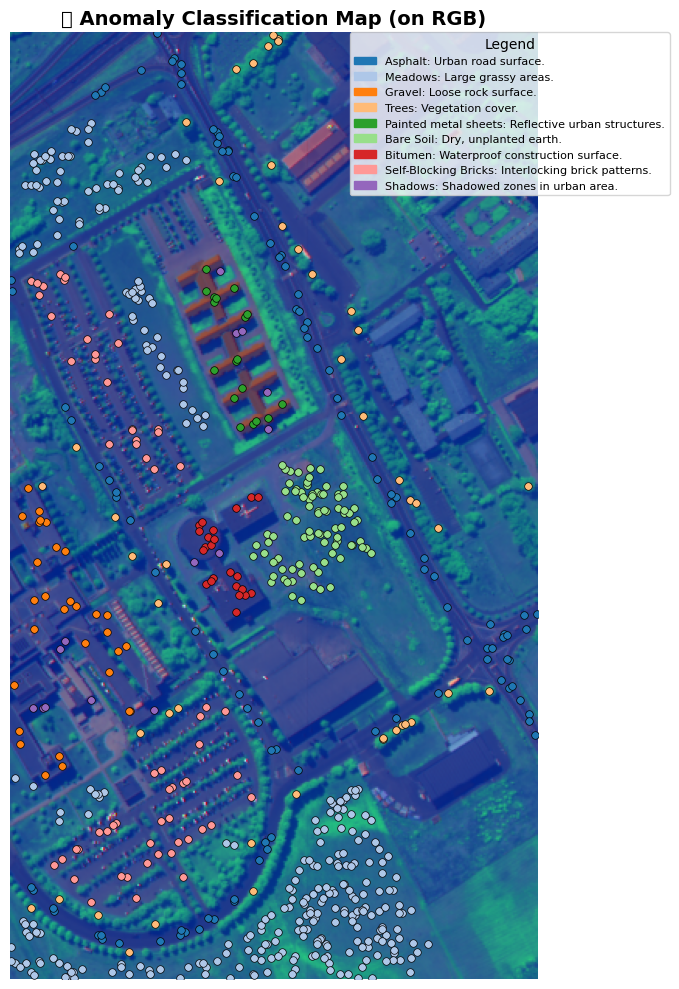

In [24]:
# Assume you have this variable
# dataset_name = data  # or "indian" or "pavia"

descriptions = metadata['descriptions']
label_to_name = metadata['label_to_name']
rgb_img = get_pca_rgb_image(data)  # Your hyperspectral image

# Assuming reconstruction_errors is defined from your anomaly detection
# and you want to detect anomalies above the 95th percentile
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold # Define 'anomalies' here

overlay_anomalies_on_rgb(rgb_img, coords_test, y_test, anomalies, label_to_name, descriptions)